# CIFAR 10 with a MLP in PyTorch

In [1]:
#install Pytorch
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.7 kB/s 
     |████████████████████████████████| 8.8 MB 36.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.


In [1]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms

## Get CIFAR
Use PyTorch Data Loaders (more next week) to get data batches

In [2]:
#transform input data (image) to tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#set batch size
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


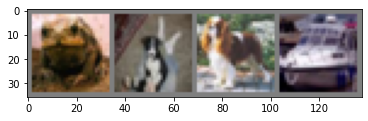

frog  dog   dog   ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next() #get data from loader!

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
#get shape of a batch -> 4D: batch_size, color_channels, y, x
images.shape

torch.Size([4, 3, 32, 32])

## Assignment
* design MLP to classify CIFAR10
* train and evaluate your model

### Notes:
* USE THE GPU! -> need to transfer the model and data to the GPU
* MLP take 1D input - CIFAR imges are 2D -> first operator of your net needs to flatten the image
* CIFAR is a multi class problem: use a SOFTMAX layer to output vector of class propabilities -> user argmax to get the class lable
* Start small: use a small net with a reducet training set and a few epochs to test your setup 

In [5]:
#compute sizes
input_size = 32*32*3 # |input|=|data| -> image size x*y*colorchannels
hidden1 = 128 #number of hidden neurons
output_size = 10 #|output|=|classes|

In [6]:
import torch 
class MLP(torch.nn.Module): #all nets inherit from nn.Module
    def __init__(self): #define layer types
        super(MLP, self).__init__()
        self.reshape = torch.flatten #2D input needs to be 1D for MLP, Note: flatten is not a class!
        self.fc1 = torch.nn.Linear(input_size,hidden1,bias=False) #1st layer input dim = 2, output =4 - | input needs to have size of data
        self.fc2 = torch.nn.Linear(hidden1,output_size,bias=False) #2nd layer input 4 out put 2 | output needs to be one for binary problem
        self.non_linear = torch.nn.Sigmoid() #non-linear activation 
    def forward(self, x): #build network
        output = self.reshape(x,start_dim=1)
        output = self.fc1(output) #w*X
        output = self.non_linear(output) # activation
        output = self.fc2(output) #w*X 
        return torch.nn.functional.log_softmax(output)

In [7]:
#get instance of perceptron model
model = MLP()

#define loss function
criterion = torch.nn.functional.nll_loss#torch.nn.CrossEntropyLoss()

#define optimizer -> SGD with learning rate lr
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [8]:
#show model
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=128, bias=False)
  (fc2): Linear(in_features=128, out_features=10, bias=False)
  (non_linear): Sigmoid()
)


In [9]:
#get num of learnable parameters in model 
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

394496

In [67]:
%%time
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    correct=0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


[1,  2000] loss: 1.374
[1,  4000] loss: 1.389
[1,  6000] loss: 1.386
[1,  8000] loss: 1.415
[1, 10000] loss: 1.413
[1, 12000] loss: 1.403
[2,  2000] loss: 1.370
[2,  4000] loss: 1.346
[2,  6000] loss: 1.361
[2,  8000] loss: 1.361
[2, 10000] loss: 1.378
[2, 12000] loss: 1.378
[3,  2000] loss: 1.337
[3,  4000] loss: 1.322
[3,  6000] loss: 1.349
[3,  8000] loss: 1.349
[3, 10000] loss: 1.339
[3, 12000] loss: 1.342
[4,  2000] loss: 1.311
[4,  4000] loss: 1.298
[4,  6000] loss: 1.304
[4,  8000] loss: 1.308
[4, 10000] loss: 1.329
[4, 12000] loss: 1.317
[5,  2000] loss: 1.277
[5,  4000] loss: 1.263
[5,  6000] loss: 1.286
[5,  8000] loss: 1.283
[5, 10000] loss: 1.292
[5, 12000] loss: 1.296
[6,  2000] loss: 1.245
[6,  4000] loss: 1.268
[6,  6000] loss: 1.263
[6,  8000] loss: 1.242
[6, 10000] loss: 1.268
[6, 12000] loss: 1.285
[7,  2000] loss: 1.228
[7,  4000] loss: 1.224
[7,  6000] loss: 1.228
[7,  8000] loss: 1.265
[7, 10000] loss: 1.243
[7, 12000] loss: 1.240
[8,  2000] loss: 1.194
[8,  4000] 

In [68]:
%%time
#test model on testset
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
model.eval()
    
for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Accuracy of the network on the 10000 test images: 46 %
CPU times: user 3.6 s, sys: 912 ms, total: 4.51 s
Wall time: 7.02 s


### Now with GPUs

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [12]:
#move model to GPU
model=model.to(device)

In [18]:
#monitor our GPU
#!pip install wandb
#import wandb
#wandb.init()

In [21]:
%%time
import time


for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    correct=0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        start = time.time()
        inputs, labels = data[0].to(device), data[1].to(device) #MOVE to GPU
        end = time.time()
        load_t=end - start


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        start = time.time()
        outputs = model(inputs)
        end = time.time()
        forward_t=end - start

        loss = criterion(outputs,labels)

        start = time.time()
        loss.backward()
        optimizer.step()
        end = time.time()
        backward_t=end - start

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(load_t, forward_t,backward_t)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


0.00016546249389648438 0.0004703998565673828 0.0007555484771728516
[1,  2000] loss: 1.071
0.00021266937255859375 0.00043082237243652344 0.0008869171142578125
[1,  4000] loss: 1.087
0.00026869773864746094 0.00046944618225097656 0.0007383823394775391
[1,  6000] loss: 1.108
0.0001666545867919922 0.0004279613494873047 0.0008220672607421875
[1,  8000] loss: 1.105
0.0002219676971435547 0.0004563331604003906 0.0007443428039550781
[1, 10000] loss: 1.116
0.00021028518676757812 0.0004260540008544922 0.0008678436279296875
[1, 12000] loss: 1.105
Finished Training
CPU times: user 34.8 s, sys: 8.22 s, total: 43 s
Wall time: 53.3 s
